<a href="https://colab.research.google.com/github/WendyX/hello-world/blob/master/Homework_5_Document_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --user --upgrade scikit-learn gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.9 MB/s eta 0:00:00


# Classification
A machine learning classifier is an algorithm that takes input (transformed documents) and a labels.  From this training data where we know the labels the algorithm and learns a set of parameters such that when it encounters previously unseen data (a new document) it can label the document appropriately.  Ideally we would create labels for a small subset of documents per haps a few hundred and want the classifier to ascribe labels to many more documents like several thousands or tens of thousands of documents.  

In our case a document is a piece of free text from the EHR, for example a progress note, surgical note, pathology report, etc.  

We are interested in ascribing labels corresponding to things like pheontypes, given the piece of text can we label the patient as having diabetes, epilepsy, CHF, or can we determine if the patient is a smoker, previousy history of smoking, or family history of cancer.  These labels can be useful for identfying candadates for studies.  

This is an interactive notebook.  Documentation and code will be presented in it. You can hit the Run button above to run code in a code cell.  Let's first import some libraries - these are tools or bits of code that you will be using.  

In [2]:
from gensim.parsing.preprocessing import stem_text, preprocess_string, remove_stopwords, strip_multiple_whitespaces
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import csv

# Loading Data
Lets first look at the data we'll be using.  It is a version of the Obesity dataset from i2b2 and is the reason you signed the data use agreement.  The data consists of discharge summaries from the Partners HealthCare Research Patient Data Repository.  It was a challenge from 2009 to identify obesity related comorbidities in discharge summaries.  Please cite the following if you use this data for research:

Uzuner Ö. (2009). "Recognizing Obesity and Co-morbidities in Sparse Data".  Journal of the American Medical Informatics Association. July 2009; 16(4): 561-570. http://jamia.bmj.com/content/16/4/561.full.pdf.

We will be using a subset of this data that has been collected and slightly processed to make using it easier within the allotted time.  See the publication for details on the raw data.  

The datafile we will be using is called: "obesity_data.csv".  The columns in the included file are below in the variable "headers".  We will load the csv into memory and get labels for the comorbidity corresponding to the column number in headers.  

In [4]:
headers = ['text', 'CAD', 'Gout', 'Venous Insufficiency', 'PVD', 'Hypercholesterolemia',
           'Hypertension', 'Asthma', 'Hypertriglyceridemia', 'OSA', 'Gallstones',
           'Depression', 'Obesity', 'GERD', 'OA', 'Diabetes', 'CHF']

def load_data(filename, label_col):
    labels = []
    text = []
    with open(filename, 'rt') as file:
        reader = csv.reader(file, delimiter='\t')
        next(reader)
        for row in reader:
            val = int(row[label_col])
            if val==1 or val==-1:
                text.append(row[0])
                if val==-1:
                    labels.append(0)
                else:
                    labels.append(1)
    return text, labels

from google.colab import files
uploaded = files.upload()

#This is a comment, the column 1 corresponds to the comorbidity CAD
col=15
print("Label we are classifying:", headers[col])
text, labels = load_data('obesity_data.csv', col)

Saving obesity_data.csv to obesity_data.csv
Label we are classifying: Diabetes


Lets look at the data we loaded, we can see the number of documents we loaded.  We can also see the number of positive (patient has Diabetes) and negative labels.  We can also look at the first patient record.

In [5]:
print("Number of documents:", len(text), "Num Diabetes:", np.count_nonzero(labels), "Num without Diabets:", (len(labels)-np.count_nonzero(labels)))

Number of documents: 624 Num Diabetes: 424 Num without Diabets: 200


In [6]:
print(text[512])

632763549 | STMHAHCC | 05016047 | | 897289 | 10/12/1998 12:00:00 AM | UNSTABLE ANGINA | Signed | DIS | Admission Date: 11/10/1998 Report Status: Signed

Discharge Date: 11/10/1998
PRINCIPAL DIAGNOSIS: CHEST PAIN
HISTORY OF HYPERTENSION
HISTORY OF INSULIN DEPENDENT DIABETES
MELLITUS
HISTORY OF CORONARY ARTERY DISEASE
HISTORY OF MYOCARDIAL INFARCTION
HISTORY OF PERIPHERAL VASCULAR DISEASE
HISTORY OF REFLUX DISEASE
STATUS POST RIGHT LOWER LEG BYPASS
HISTORY OF CONGESTIVE HEART FAILURE
HISTORY OF PRESENT ILLNESS: The patient is a 69 year old
Spanish speaking woman with a history
of significant coronary artery disease and other medical problems
as stated above who presented to us in the Emergency Department
complaining of chest pain. The patient was admitted recently on
January for bilateral iliac percutaneous transluminal coronary
angioplasty and received a popliteal to posterior tibial bypass
with saphenous vein on the right lower extremity. This was
complicated by a non-Q wave myocardial

In [7]:
print(labels)

[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 

# Preprocessing
The machine learning classifier does not take text in directly it needs it to be preprocessed into a machine computable form.  Often this is a vector where each dimension is a feature, often for text classification each feature corresponds to a word.  This can lead to large unweildy vectors that are very sparse for example if we include all words in all documents a dimension could include mispellings or numbers which only occur once.  

We need to perform preprocessing to reduce some of the dimensionality which can help to improve classification performance as well as the speed of learning and classifying new documents.  There are many types of preprocessing for example converting text to all lower case.  


## Stopwords
We can remove stopwords - these are words that are very frequent in the English language but contain little information. Word classes such as prounouns: I, me, my, she, he, it, us, you, your; determiners (definte/indefinite articles, posssive, interrogative, demonstrative): the, a, their, what, whose, this, those, that. Some stopwords such as no or not might be useful to keep if you are using ngram features.  Ngrams are multiword phrases where n is usually 2 or 3, this can be useful in capturing negation like "not have diabetes", "no CHF symptoms".  


In [8]:
sentences = ["An apple a day keeps the doctor away.","The patient doesn't have CHF"]
v = CountVectorizer(stop_words='english')
print('Removing stopwords:', v.fit(sentences).vocabulary_.keys())
print()
v = CountVectorizer(ngram_range=(1, 3), stop_words='english')
print('Removing stopwords and ngrams size 1-3:', v.fit(sentences).vocabulary_.keys())
print()
v = CountVectorizer(ngram_range=(1, 3))
print('Ngrams size 1-3:', v.fit(sentences).vocabulary_.keys())

Removing stopwords: dict_keys(['apple', 'day', 'keeps', 'doctor', 'away', 'patient', 'doesn', 'chf'])

Removing stopwords and ngrams size 1-3: dict_keys(['apple', 'day', 'keeps', 'doctor', 'away', 'apple day', 'day keeps', 'keeps doctor', 'doctor away', 'apple day keeps', 'day keeps doctor', 'keeps doctor away', 'patient', 'doesn', 'chf', 'patient doesn', 'doesn chf', 'patient doesn chf'])

Ngrams size 1-3: dict_keys(['an', 'apple', 'day', 'keeps', 'the', 'doctor', 'away', 'an apple', 'apple day', 'day keeps', 'keeps the', 'the doctor', 'doctor away', 'an apple day', 'apple day keeps', 'day keeps the', 'keeps the doctor', 'the doctor away', 'patient', 'doesn', 'have', 'chf', 'the patient', 'patient doesn', 'doesn have', 'have chf', 'the patient doesn', 'patient doesn have', 'doesn have chf'])


## Stemming
Stemming is often a heuristic proccess of reducing inflected forms to a similar base for example organize, organizes, organized and organizing.  Similarly there are dereivationally related words with similar meetings that can be reduced such as democarcy, democratic and democratization.  

The goal is to reduce sparsity which can hurt classifier performance.  However, stemming can contribute to increased polysemy: operate, operating, operates, operation, operative, operatives and operational all stem to "oper" using the Porter stemming algorithm.  

In [9]:
print(stem_text("Is it universally true? Some say the university is the best in the Universe."))

is it univers true? some sai the univers is the best in the universe.


# Classification Algorithms
Different types of preprocessing can be combined to generate a feature vector.  These feature vecters are used as input to the classifier.  Both the preprocessing type, classification algorithms and tunable parameters for the classification algorithm will impact performance.  

There are many types of classification algorithms such as Support Vector Machines (SVM), Random Forest, Decision Trees, etc. We will not go into specifics of them and will treat them as black boxes.  It is important to know that each algorithm has default parameters but they can be changed.  What is important is understanding the resulting metrics from a classifier to determine its' performance.

## Metrics
There are many different metrics available to evaluate classifier performance.  Each metric depends on the underlying dataset - for example the number of labels employed (in our case it is 2) and the poportion of labels within the dataset.  It also depends on the desired application of the classifier.  

See the confusion matrix below. Because we are using binary labels (postive and negative) metrics will be addressed in terms of true postive - a document classification is positive and the label is positive. False positive - a document is classified as potitive but its' label is negative. False negative - a document is classified as negative but its' label is positive.  True negative - both the classfication of a document and its' label are negative.

![Confusion Matrix](confusion_matrix.png)


### Accuracy
Accuracy is the proportion of documents correctly labeled by the classifer divided by the total number of documents the classifier has labeled.  For example accuacy is 90% if the classifier correctly labels 90 documents out of 100 that it labels.  Another way to think of this is (true positives + true negatives) / (total number of documents classified). This metric is only useful for balanced datasets where the proportion of labels is roughly equal.  A classifier can obtain 90% accuracy by only assigning one label if that label represents 90% of the documents.  

### Precision
Precision is a metric of preciseness it is the number of true postives/(true positives + false postivies).  Or another way to think of this is how often is the classifier correct when it labels a document as positive.  

This metric is important when the goal of the task is to make sure all the things you label as postive are positive.  

### Recall
Recall is also the true positive rate or sensitvity.  It is true postivies/(true positives + false negatives) or in otherwords how many true positive documents do you label over all positive documents.    

This metric is important when the goal of the task is to make sure we don't miss any potential positives.  

Precision and recall are not mutually exclusive but in practice due to algorithm implementations there are often trade offs between precision and recall.  Usually one optimizes at the expense over the other.  It is important to understand what is most important to your task.

### F1
The F measure combines precision and recall scoress it is the harmonic mean: F1 = 2 * ((precision * recall)/(precision + recall)).  It is a way of combing precision and recall into a single number of overall performance to compare various classifiers.  In F1 precision and recall are evenly weighted, this weighting can be changed if precision or recall is more important than the other.

In [15]:
#Scoring metrics we're interested in
scoring = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

#Want to initialize the random number generator with the same seed for reapeatable experiments
random_state = 198273

#Our preprocessing steps
def preprocess(X):
        return preprocess_string(X, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text])

#Notice the count vectorizer/tfididf trnasformer.  We are using a pipeline here so we are first applying the
#steps in preprocess (converting the string to lowercase, removing multiple spaces, removing stopwords then stemming).
#This is followed by the count vectorizer then the tfidf transformer.
preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
])

features = preprocess_pipeline.fit_transform(text)
for clf in [
        RandomForestClassifier(),
        MultinomialNB(),
        SVC(kernel='linear', class_weight='balanced'),
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=5, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

Classifier: RandomForestClassifier()
Accuracy: 0.754658064516129
Precision: 0.7416276468466109
Recall: 0.9834173669467787
F1: 0.8453749375055919

Classifier: MultinomialNB()
Accuracy: 0.679483870967742
Precision: 0.679483870967742
Recall: 1.0
F1: 0.8091575091575092

Classifier: SVC(class_weight='balanced', kernel='linear')
Accuracy: 0.8203612903225806
Precision: 0.8508430024546435
Recall: 0.893781512605042
F1: 0.871061269430459

Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.8942193548387097
Precision: 0.9337096330711827
Recall: 0.9102521008403361
F1: 0.9211332841571342



## Question 1: Classification Analysis
You have now seen an example of document classification from start to finish.  In the box below write a few paragraphs comparing the performance of the various algorithms.  Some questions to think about:

Is accuracy an appropriate metric given the number of documents with Diabetes vs without?  
In what context would precision be more importatant than recall?
When would the opposite be true?


Accuracy is an appropriate metric when the number of documents with and without Diabetes is similar. In this case, the number of documents with diabetes is about 2 times the number of documents without. I think in this case it is still appropriate.

Precision is more important in contexts where the cost of a false positive is high. For example, a false positive of cancer can trigger a lot of downstream testing and emotional burden.

Recall is crucial in situations where failing to identify a positive case has serious consequences. For example, a heart attack.

## Question 2: Effects of preprocesing
Now that you have seen a classification example, experiment with different types of features - you can modify the preprocess function below by changing the filters array: [lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text] you can add or remove preprocessing functions, alternatively you can modify the preprocess_pipeline:

preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
])

by removing the TfidfTransformer, or passing different parameters into TfidfTransformer or the CountVectorizer (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  

Perform at least 3 modifications from the baseline case above and write an analysis answering the questions in the box below.  

In [20]:
#Our preprocessing steps
def preprocess(X):
        return preprocess_string(X, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text])

#Notice the count vectorizer/tfididf trnasformer.  We are using a pipeline here so we are first applying the
#steps in preprocess (converting the string to lowercase, removing multiple spaces, removing stopwords then stemming).
#This is followed by the count vectorizer then the tfidf transformer.
preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess)),#, max_df = 0.95)),
    ('tfidf', TfidfTransformer()),
])

features = preprocess_pipeline.fit_transform(text)
for clf in [
        RandomForestClassifier(),
        MultinomialNB(),
        SVC(kernel='linear', class_weight='balanced'),
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=5, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

Classifier: RandomForestClassifier()
Accuracy: 0.7355096774193548
Precision: 0.728851810106006
Recall: 0.9740336134453782
F1: 0.8336475132599602

Classifier: MultinomialNB()
Accuracy: 0.679483870967742
Precision: 0.679483870967742
Recall: 1.0
F1: 0.8091575091575092

Classifier: SVC(class_weight='balanced', kernel='linear')
Accuracy: 0.7771225806451614
Precision: 0.8334360160049725
Recall: 0.8395238095238096
F1: 0.8358026633907816

Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.9118451612903226
Precision: 0.932849775243756
Recall: 0.9385714285714286
F1: 0.9352397480913739



1.  Describe what you modified.
2.  What is the intention of the modfications? What did you hope that the modifications would do?
3.  Were the modifications successful?
4.  Compare performance to the baseline case.

Modification 1:
1.  Describe what you modified.
- I removed the TfidfTransformer
2.  What is the intention of the modfications? What did you hope that the modifications would do?
- This change will make the classification rely purely on raw counts from CountVectorizer. So it no longer takes the document length and term frequency across documents into consideration. This might affect the model's ability to handle common words that could be less informative about the document's class.
3.  Were the modifications successful? Yes
4.  Compare performance to the baseline case.
- It did not change the performance much. The accuracy, precision, recall and F1 might be slightly better for RandomForestClassifier, MultinomialNB, SVC, but worse for DecisionTreeClassifier than before.

Modification 2:
1.  Describe what you modified.
- modified the parameter for CountVectorizer, added max_df = 0.95
2.  What is the intention of the modfications? What did you hope that the modifications would do?
- This removes terms that appear in 95% of the documents. This helps reduce the weight of very common words that might not be useful in differentiating  
3.  Were the modifications successful? Yes
4.  Compare performance to the baseline case.
- the performance of the new model is slightly better for RandomForestClassifier but not others.

Modification 3:
1.  Describe what you modified.
- Remove remove_stopwords and stem_text
2.  What is the intention of the modfications? What did you hope that the modifications would do?
- Not removing the stop words might allow the model to make better use of sentence structure.
3.  Were the modifications successful? Yes
4.  Compare performance to the baseline case.
The performance is slightly worse across all models.

## Question 3: Model Evaluation:

- In addition to accuracy, precision, recall, and F1 score, also calculate the ROC AUC score for each classifier. Compare the ROC AUC scores - which classifier has the highest AUC? What does this metric tell you about discriminative power?

  *   Decision tree has the highest ROC AUC score. This suggests that the decision tree classifier has the highest discriminative power.


- Plot the precision-recall curves for each classifier. At what recall level does precision start to drop off substantially for each one? What does this tell you about which classifier to use if you need high recall vs high precision?



  *   for random forest, when recall reaches about 0.2; for multinomial NB, it had a dip in the curve when recall is about 0.1; SVC, when recall = 0.25; decision tree, when recall = 0.9


- Print out the confusion matrix for each classifier. Which one has the most balanced performance across the classes? Which ones are making more false positive vs false negative errors?

  *   None of them is very balanced. Decision Tree is relatively more balanced. Most False Positives: The Multinomial NB; Most False Negatives: no one significantly, SVC more than decision tree.






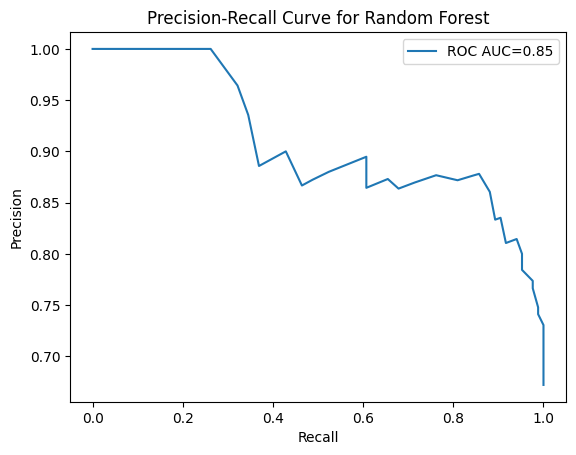

Confusion Matrix for Random Forest:
[[ 7 34]
 [ 0 84]]


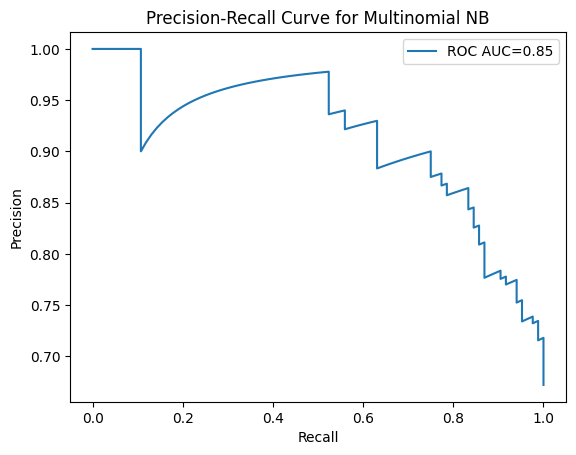

Confusion Matrix for Multinomial NB:
[[ 0 41]
 [ 0 84]]


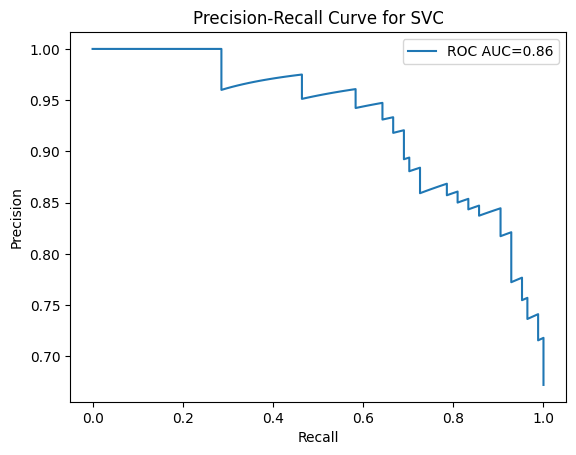

Confusion Matrix for SVC:
[[24 17]
 [ 6 78]]


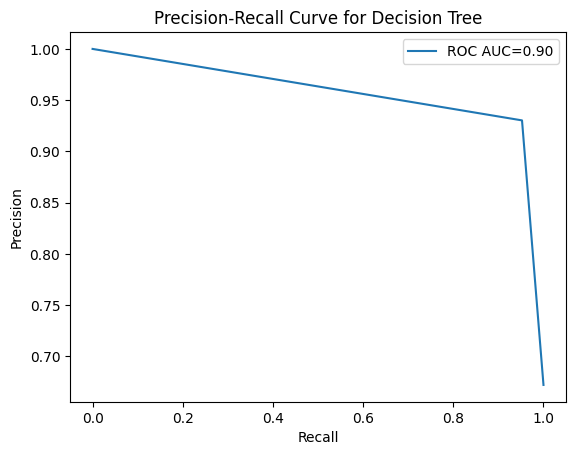

Confusion Matrix for Decision Tree:
[[35  6]
 [ 4 80]]


In [37]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

# Define your preprocess and other necessary functions here

def preprocess(X):
    return preprocess_string(X, filters=[lambda x: x.lower(), strip_multiple_whitespaces])

# Setup the pipeline
preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
])

# Load and transform the data
features = preprocess_pipeline.fit_transform(text)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=60)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Multinomial NB": MultinomialNB(),
    "SVC": SVC(kernel='linear', class_weight='balanced', probability=True),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=60)
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    model = clone(clf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f'ROC AUC={roc_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {name}')
    plt.legend()
    plt.show()

    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))


## Question 4 Feature Extraction:
(you can try this only on your best performing model)
- Try using word embeddings like word2vec or GloVe vectors as features instead of TF-IDF. Does this improve or worsen performance? Why do you think this is?

It made the performance worse. maybe clinical notes contains too much domain-specific language


- Experiment with one or two adding other textual features like document length, average word length, readability scores, etc. Do any of these metadata features provide useful signal?

After incorporating these metadata, it does not seem to help either.

- Try different n-gram ranges in the CountVectorizer. Do bigrams or trigrams improve over just unigrams? At what point do larger n-grams start to hurt due to sparsity?

Bigrams and trigrams do improve the performance. When it reaches 4 it starts to hurt.

In [63]:
!pip install textstat

import numpy as np
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, train_test_split
from textstat import flesch_reading_ease


# Custom transformer to preprocess text and compute Word2Vec embeddings
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=2, workers=4):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
        self.w2v = None

    def fit(self, X, y=None):
        # Assuming X is a list of tokenized texts
        self.model = Word2Vec(X, vector_size=self.size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.w2v = {w: vec for w, vec in zip(self.model.wv.index_to_key, self.model.wv.vectors)}
        return self

    def transform(self, X):
        # Average Word2Vec vectors for each document
        return np.array([
            np.mean([self.w2v.get(w, np.zeros(self.size)) for w in words], axis=0)
            for words in X
        ])

# Preprocessing function to tokenize and preprocess text
def preprocess(X):
    from gensim.parsing.preprocessing import preprocess_string, strip_multiple_whitespaces, remove_stopwords, stem_text
    # Apply preprocessing steps
    return [preprocess_string(x, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text]) for x in X]

# Set up the pipeline
preprocess_pipeline = Pipeline([
    ('preprocess', make_pipeline(Word2VecVectorizer(size=100, window=5, min_count=2))),
])

features = preprocess_pipeline.fit_transform(text)
for clf in [
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=5, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.7 MB/s eta 0:00:00


Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.6088645161290323
Precision: 0.7049152419761514
Recall: 0.7286274509803922
F1: 0.7161252479451334



In [67]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from textstat import flesch_reading_ease
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate

# Assuming preprocess returns a list of lists of words (tokens)
def preprocess(X):
    from gensim.parsing.preprocessing import preprocess_string, strip_multiple_whitespaces, remove_stopwords, stem_text
    return [preprocess_string(x, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text]).split() for x in X]

# Feature extractors
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=100, window=5, min_count=2, workers=4):
        self.size = size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
        self.w2v = None

    def fit(self, X, y=None):
        self.model = Word2Vec(X, vector_size=self.size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.w2v = {w: vec for w, vec in zip(self.model.wv.index_to_key, self.model.wv.vectors)}
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v.get(word, np.zeros(self.size)) for word in text], axis=0)
            for text in X
        ])

class TextualMetadataTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            [len(text), np.mean([len(word) for word in text]), flesch_reading_ease(' '.join(text))]
            for text in X
        ])

# Full pipeline
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('w2v', Word2VecVectorizer(size=100, window=5, min_count=2)),
        ('meta', TextualMetadataTransformer())
    ])),
    ('scale', StandardScaler())
])

features = pipeline.fit_transform(text)
for clf in [
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=5, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.578490322580645
Precision: 0.6936814674428049
Recall: 0.6792156862745097
F1: 0.6861021798766997



In [74]:
#Our preprocessing steps
def preprocess(X):
        return preprocess_string(X, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text])

#Notice the count vectorizer/tfididf trnasformer.  We are using a pipeline here so we are first applying the
#steps in preprocess (converting the string to lowercase, removing multiple spaces, removing stopwords then stemming).
#This is followed by the count vectorizer then the tfidf transformer.
preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
])

features = preprocess_pipeline.fit_transform(text)
for clf in [
        RandomForestClassifier(),
        MultinomialNB(),
        SVC(kernel='linear', class_weight='balanced'),
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=5, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Classifier: RandomForestClassifier()
Accuracy: 0.748283870967742
Precision: 0.7431776797294039
Recall: 0.9645938375350142
F1: 0.8392336763765336

Classifier: MultinomialNB()
Accuracy: 0.679483870967742
Precision: 0.679483870967742
Recall: 1.0
F1: 0.8091575091575092

Classifier: SVC(class_weight='balanced', kernel='linear')
Accuracy: 0.7930838709677419
Precision: 0.8344708985699636
Recall: 0.8701680672268907
F1: 0.8508028675581327

Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.9118967741935483
Precision: 0.94360074757659
Recall: 0.926890756302521
F1: 0.93479516289452



## Question 5 Train/Test Splits and Cross-Validation:
(you can try this only on your best performing model)
- Instead of 5-fold CV, try 10-fold. Does the larger number of folds lead to less variance in scores across folds?



  *   Yes it does.


- Instead of KFold CV, try RepeatedKFold or RepeatedStratifiedKFold. This will shuffle and repeat the CV process multiple times. Do the averaged scores have narrower confidence intervals?



  *   Yes, they have a narrower confidence intervals


- Hold out a separate test set first before doing cross-validation on the training set. This will give you a final unbiased estimate of generalization error in addition to the CV scores.




In [77]:
#Scoring metrics we're interested in
scoring = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

#Want to initialize the random number generator with the same seed for reapeatable experiments
random_state = 198273

#Our preprocessing steps
def preprocess(X):
        return preprocess_string(X, filters=[lambda x: x.lower(), strip_multiple_whitespaces, remove_stopwords, stem_text])

#Notice the count vectorizer/tfididf trnasformer.  We are using a pipeline here so we are first applying the
#steps in preprocess (converting the string to lowercase, removing multiple spaces, removing stopwords then stemming).
#This is followed by the count vectorizer then the tfidf transformer.
preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
])

features = preprocess_pipeline.fit_transform(text)
for clf in [
        RandomForestClassifier(),
        MultinomialNB(),
        SVC(kernel='linear', class_weight='balanced'),
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=10, return_train_score=False)
    print("Classifier:", clf)
    #print(scores)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()

Classifier: RandomForestClassifier()
Accuracy: 0.7545570916538659
Precision: 0.7483932030307403
Recall: 0.9644518272425249
F1: 0.8424371852919139

Classifier: MultinomialNB()
Accuracy: 0.6794674859190989
Precision: 0.6794674859190989
Recall: 1.0
F1: 0.8091436865021772

Classifier: SVC(class_weight='balanced', kernel='linear')
Accuracy: 0.8137480798771122
Precision: 0.851617596931421
Recall: 0.879125138427464
F1: 0.8641171832431903

Classifier: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=198273)
Accuracy: 0.8941628264208908
Precision: 0.934929886866926
Recall: 0.9100775193798449
F1: 0.9209683636732887



In [81]:
# Scoring metrics we're interested in
scoring = {'acc': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# Want to initialize the random number generator with the same seed for repeatable experiments
random_state = 198273

preprocess_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

# Assuming 'text' is your input data and 'labels' are the corresponding labels
features = preprocess_pipeline.fit_transform(text, labels)

# Using RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

for clf in [
        RandomForestClassifier(random_state=random_state),
        MultinomialNB(),
        SVC(kernel='linear', class_weight='balanced'),
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=random_state)
    ]:
    scores = cross_validate(clf, features, labels, scoring=scoring,
                         cv=cv, return_train_score=False)
    print("Classifier:", clf.__class__.__name__)
    print("Accuracy:", scores['test_acc'].mean())
    print("Precision:", scores['test_precision'].mean())
    print("Recall:", scores['test_recall'].mean())
    print("F1:", scores['test_f1'].mean())
    print()


Classifier: RandomForestClassifier
Accuracy: 0.7747329032258067
Precision: 0.7588542458548734
Recall: 0.9825490196078432
F1: 0.8560203261552278

Classifier: MultinomialNB
Accuracy: 0.679483870967742
Precision: 0.679483870967742
Recall: 1.0
F1: 0.8091575091575092

Classifier: SVC
Accuracy: 0.7872077419354838
Precision: 0.8431492202443956
Recall: 0.8448403361344538
F1: 0.8434494522140163

Classifier: DecisionTreeClassifier
Accuracy: 0.909313548387097
Precision: 0.9333789250671947
Recall: 0.9339719887955181
F1: 0.9333760156080407



## Question 6: Evaluation:
In 2 paragraphs, summarize your findings on what models, features, and CV strategies worked best. Discuss the tradeoffs between different approaches. Make a final recommendation on what you think is the optimal classifier and preprocessing pipeline for this task based on the empirical results and your domain expertise. Explain your reasoning.

In our experimentation, we evaluated several classifiers, including RandomForestClassifier, MultinomialNB, SVC, and DecisionTreeClassifier. We also used different preprocessing pipelines and cross-validation strategies.

The choice of classifier significantly impacted performance. In this case, decision tree has the best performance. Additionally, employing text preprocessing steps such as lowercasing, removing stopwords, and stemming improved classification results across models.

For cross-validation strategies, utilizing RepeatedStratifiedKFold tend to yielded more stable and reliable performance estimates compared to standard KFold, reducing variance and providing narrower confidence intervals for the averaged scores.

Considering the trade-offs, our recommendation for the optimal classifier and preprocessing pipeline would be decision tree with the text preprocessing pipeline consisting of lowercasing, removing stopwords, and stemming, followed by CountVectorizer and TfidfTransformer. This choice balances performance, computational efficiency, and robustness, making it suitable for many text classification tasks, including the one at hand.